<img src="https://drive.google.com/uc?id=1dtR470-kr9MhA_vytTgnLtdrr5X7HaXu" width="150"/>

### Name: [Olga Kostur]
### CID: [02162786]

# Instructions:

Follow the instructions below to complete the coursework and submit it:

1. Read the materials you will need to complete the coursework; you can find them in the github classroom repo provided together with this notebook. The provided materials are: 

  - The paper [*Gradient based learning applied to document recognition*](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf) by Yann LeCunn where he describes the original form of the LeNet-5 architecture.

  - The paper [*Visualizing the Loss Landscape of Neural Nets*](https://arxiv.org/pdf/1712.09913.pdf).

  - This Jupyter Notebook template to fill in your answers (it contains some code to assist you).


2. Complete your coursework using this provided Jupyter Notebook template (use Google Colab or your local machine if it has a GPU and/or sufficient computational power).

3. Once you have completed your answers, upload your final notebook to the repo you got from the github classroom link (as you normally do). Make sure to have all the answers in there:

   - **All the cells in your final Jupyter Notebook should be executed before saving and uploading to github in order to have the output of the cells available in the uploaded version** (images you plot, training graphs generated with `livelossplot`, etc). We will not guarantee that if some code blocks are missing we will be able to rerun them for you.

   - Add comments in the code to explain what you are doing at every step. 

   - All answers requiring written answers (ie, not code) should be in markdown blocks in the Jupyter Notebook. This provided Jupyter Notebook template has allocated blocks for the questions, but you can add any coding or markdown blocks that you need.

4. The coursework is released on **Friday 13 May at 15:30h BST**, and the answers have to be submitted on **Saturday  21 May, 23:59h BST**. We will not accept late submissions.

    ***[BST stands for British Summer Time (local UK time)]***

<br>

---
<br>

### The coursework consists of a number of questions/exercises you have to complete. You will find them below.

## Imports

In [1]:
# your import\s and initial checks here
import numpy as np
import pandas as pd
import os
import random

import matplotlib.pyplot as plt
from matplotlib import cm
from random import seed
from random import randint

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import torchvision.transforms as transforms

from livelossplot import PlotLosses
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit

def set_seed(seed):
    """
    Use this to set ALL the random seeds to a fixed value and take out any randomness from cuda kernels
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = False  ##uses the inbuilt cudnn auto-tuner to find the fastest convolution algorithms. -
    torch.backends.cudnn.enabled   = False

    return True

In [3]:
device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")

No GPU available!


## 1-Load the medical MNIST dataset [10 points]
Go to this [kaggle dataset](https://www.kaggle.com/datasets/andrewmvd/medical-mnist/code) and download the data (see provided snippets below).

Format the data as you see fit to use it in your next questions. Explain the process you follow.

[**It is recommended that you convert the images to grayscale using** *torchvision transforms*]

Use the following snippets of code to help you download the data first:

In [19]:
# Get kaggle authentication json
! mkdir ~/new/.kaggle
#! cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
! cp /Users/olgakostur/kaggle.json ~/.kaggle/

! ls ~/.kaggle
! chmod 600 ~/.kaggle/kaggle.json

mkdir: /Users/olgakostur/new: No such file or directory
cp: /Users/olgakostur/kaggle.json: No such file or directory
chmod: /Users/olgakostur/.kaggle/kaggle.json: No such file or directory


In [11]:
# Download and unzip dataset
! kaggle datasets download -d andrewmvd/medical-mnist
! mkdir ./medical-mnist
! unzip -q ./medical-mnist.zip -d medical-mnist

Traceback (most recent call last):
  File "/Users/olgakostur/mambaforge/envs/bda/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/Users/olgakostur/mambaforge/envs/bda/lib/python3.8/site-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/Users/olgakostur/mambaforge/envs/bda/lib/python3.8/site-packages/kaggle/api/kaggle_api_extended.py", line 164, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /Users/olgakostur/.kaggle. Or use the environment method.
mkdir: ./medical-mnist: File exists
unzip:  cannot find or open ./medical-mnist.zip, ./medical-mnist.zip.zip or ./medical-mnist.zip.ZIP.


The above code snippets did not work for me, hence data is first downloaded directly from linked kaggle website and opened using ImageFolder. ImageFolder is a generic dataloader that is commonly used to load images that are not in pytorch defalt datasets and required specific organisatrion (as in medical-mnist dataset):

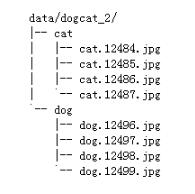

It returns Dataset object with contains tuples => (image, class).

In [4]:
import torchvision
from torchvision.datasets import ImageFolder
from torchvision import transforms as T

dataset = ImageFolder('medical-mnist', transforms.ToTensor())

print(dataset)
print('\nWe have {} images in our dataset'.format(len(dataset)))
print('\nThere are {} clasees:'.format(len(dataset.classes)), dataset.classes)
print('\n The classes correspond to indexes, stored in dataset as follows: \n', dataset.class_to_idx)

Dataset ImageFolder
    Number of datapoints: 58955
    Root location: medical-mnist
    StandardTransform
Transform: ToTensor()

We have 58955 images in our dataset

There are 6 clasees: ['AbdomenCT', 'BreastMRI', 'CXR', 'ChestCT', 'Hand', 'HeadCT']

 The classes correspond to indexes, stored in dataset as follows: 
 {'AbdomenCT': 0, 'BreastMRI': 1, 'CXR': 2, 'ChestCT': 3, 'Hand': 4, 'HeadCT': 5}


In [5]:
#Creating data loader
dataloader = DataLoader(dataset=dataset, batch_size=64)

In [6]:
# Normalising images. This helps get data within a range and reduces the skewness 
# It is important for deep neural networks because floating point values within a smaller range increase 
# Normalization can also tackle the diminishing and exploding gradients problems.

#Hence we need to compute the mean and standard deviation.
mean = 0.
std = 0.
for images, _ in dataloader:
    batch_samples = images.size(0) # batch size (the last batch can have smaller size!)
    images = images.view(batch_samples, images.size(1), -1)
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)

mean /= len(dataloader.dataset)
std /= len(dataloader.dataset)

print(mean, std)

tensor([0.3583, 0.3583, 0.3583]) tensor([0.2015, 0.2015, 0.2015])


In [166]:
#Building a transformer
#Grayscale() converts the number of channnels from 3 to 1
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(0.3583, 0.2015),
                                transforms.Grayscale()])


#Re-loading data with required normalisation.
dataset_normalised = ImageFolder('medical-mnist', transform=transform)

#Recreating dataloader
data_loader_normalised = DataLoader(dataset=dataset_normalised , batch_size = 64)

#Checking that conversion to Grayscale has changed the number of channels from 3 to 1
#The structure of data is the following image, class, channels, width, heights
print('Before conversion to grayscale the dimentions of images:', dataset[0][0].size())
print('After conversion to grayscale the dimentions of images:', dataset_normalised[0][0].size())


Before conversion to grayscale the dimentions of images: torch.Size([3, 64, 64])
After conversion to grayscale the dimentions of images: torch.Size([1, 64, 64])


## 2-Plot data [5 points]
Plot 25 images of the training set together with their corresponding label names.






In [8]:
# function to return key for any value
value_dict = dataset_normalised.class_to_idx
def get_key(val):
    for key, value in value_dict.items():
         if val == value:
                return str(str(key) + ' ' + str(value))
 
    return "key doesn't exist"


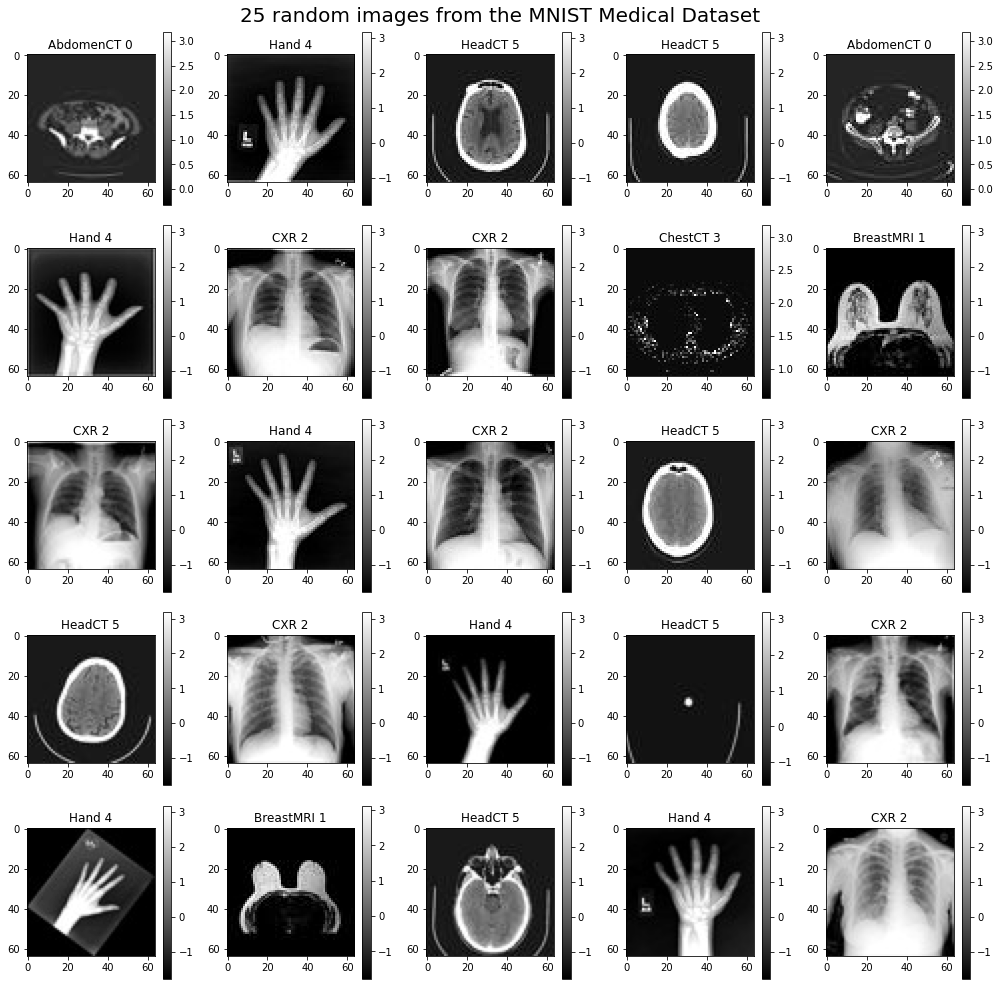

In [9]:
fig=plt.figure(figsize=(14, 14))
columns = 5
rows = 5

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(columns, rows, i)
    j = randint(0, len(dataset_normalised))
    plt.imshow(np.reshape(dataset_normalised[j][0], (64,64)), cmap=cm.gray)
    plt.gca().set_title(get_key(dataset_normalised[j][1]))
    plt.colorbar()
plt.suptitle('25 random images from the MNIST Medical Dataset', fontsize=20)
fig.tight_layout()
plt.show()

#+ ' ' + str(dataset_normalised[j][1])

## 3-Prepare your LeNet-5 network [10 points]
Use the code provided in the Jupyter Notebook template and modify it as you see fit to be able to perform a forward pass using a single dummy tensor input **x**.

Do you need to modify the size of any layers of the network for the Medical MNIST dataset? If yes, explain how you did it and implement the changes.

The lines of code that will do the forward pass and print the network are provided in the template.

The dimentions of our input images are 64 x 64
Hence to modify image to 28 x 28 pixels we need to adjust the values of stride and padding

The formula calculating output dimention is:
[(W−K+2P)/S]+1

- W is the input dimention (64)
- K is the Kernel size     (5)
- P is the padding 
- S is the stride 

In [10]:
#This for loop creates pairs of values of stride and padding in the ranges (0 -50) & (1-51)
#Then, using the above formula it computes the dimentions of output layer and gives us 
#values oif padding and stride that yield 28x28

p = np.arange(0,50)
s = np.arange(1,51)

dimentions = []
for i in p:
    for j in s:
        d = (((64 -5 +2*i)/j) +1) 
        if d == 28:
            print('The dimention {} was achiieved with padding - {} and stride - {}'.format(d, i, j))
        dimentions.append([d])
        j+=1
    i+=1


The dimention 28.0 was achiieved with padding - 11 and stride - 3
The dimention 28.0 was achiieved with padding - 38 and stride - 5


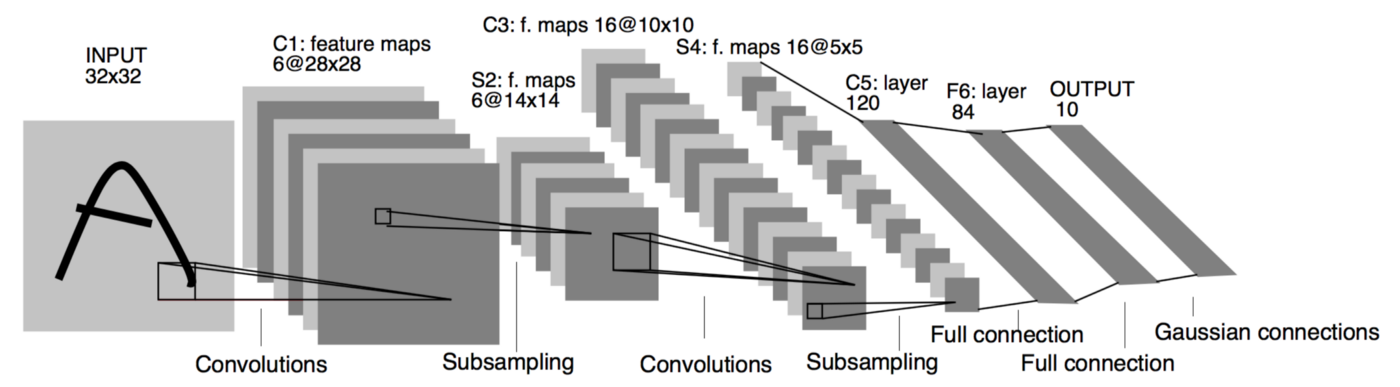

In [1]:
cnn = Sequential()
cnn.add(Conv2D(1, (2,2), activation='relu', padding='same', input_shape=(10,10,1)))
cnn.add(MaxPooling2D(pool_size=(2, 2)))
cnn.add(Flatten())

NameError: name 'Sequential' is not defined

## 4-Create a training, validation split [5 points]
Split the data using `sklearn.model_selection.StratifiedShuffleSplit`:

- 90\% of the data in the training set
- 10\% of the data in the validation set

Verify the stratified shuffle split by plotting a histogram of the classes in the training and validation set.

Prepare the downloaded datasets to be used with your modified network from the previous section.

In [12]:
# split the data
shuffler = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42).split(dataset_normalised, dataset_normalised.targets) 
indices = [(train_idx, validation_idx) for train_idx, validation_idx in shuffler][0]

In [16]:
# create training and validation sets

#We take each index generated by StratifiedShuffleSplit and by indexing in dataset_normalised[index] it gives
#a tuple of tensor and corresponding class, hence we choose [i][0] for X and [i][1] for y

X_train, y_train = [dataset_normalised[i][0].float() for i in indices[0]], [dataset_normalised[i][1] for i in indices[0]]
X_val, y_val = [dataset_normalised[i][0].float() for i in indices[1]], [dataset_normalised[i][1] for i in indices[1]]

In [17]:
#Splitting again to get the test set
shuffler = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42).split(X_train, y_train) 
indices = [(train_idx, test_idx) for train_idx, test_idx in shuffler][0]

In [18]:
X_training, y_training = [X_train[i] for i in indices[0]], [y_train[i] for i in indices[0]]
X_test, y_test = [X_train[i] for i in indices[1]], [y_train[i] for i in indices[1]]

In [19]:
medical_train = TensorDataset(torch.stack(X_training), torch.Tensor(y_training).long())
medical_validate = TensorDataset(torch.stack(X_val), torch.Tensor(y_val).long())
medical_test = TensorDataset(torch.stack(X_test), torch.Tensor(y_test).long())

## 5-Grid search [20 points]
From  the  list  below,  select  two  hyperparameters  and  perform  a  2D  grid-search  to  find  the  optimal values for these two hyperparameters.  The range of values to test are provided.  Justify your choice of the two hyperparameters you want to tune (write a paragraph in a markdown cell explaining why you chose these two particular parameters). 

The list of hyperparameters to choose from is:

a)  Random Number Seed:  **42**  [31, 42, 53] \
b)  Learning Rate:  **1e-2**  [1e-1, 1e-2, 1e-3] \
c)  Momentum:  **0.5**  [0.2, 0.5, 0.8] \
d)  Batch Size:  **64**  [64, 128, 512] \
e)  Number of epochs:  **30**  [10, 30, 50]

The **values in bold** next to each hyperparameter are the values you need to use if you are not tuning this particular hyperparameter.  The values between square brackets are the values to use if you choose to tune this particular hyperparameter. Fixed hyperparameters:

- Optimiser: SGD+momentum
- Test batch size: 1000

Write the results in two tables (one for the loss and one for the accuracy) where the columns and rows are the first and second hyperparameter have selected. You can use markdown tables or create the table in python.

Using *livelossplot* to display the training of some grid-search runs (don't need to plot all of them, choose the ones you think are more relevant to explain your hyperparameter search strategy).

Select the best values for the two hyperparameters you have chosen to optimise and **justify your choice**.

Here two hyperparameters will be trained - Lerning Rate and Momentum.

These two hyperparameters will effect the model training the most, while Random Number Seed just fixes teh random generation values, batch size in most cases are set to 32(here 64) as a standard volume of datasubsets and number of epochs can only have slight improvement but not sufficient to see major difference between 30 and 50 epochs. In fact choosing too many epochs may lead to overfitting, hence 30 is a sweets spot. 

- Learning Rate - is one of the most important hyperparameters. It scales the magnitude of the model’s weight updates in order to minimize the model’s loss. Too small leads to long training process that could get stuck, whereas a value too large may result in learning too fast or an unstable training process.

- Momentum - Momentum is an extension to the gradient descent optimization algorithm (follows the negative gradient of a function to find the mimimum (global or local). Momentum adds inertia to this process and overcomes oscillations of noisy gradients, so that we arrive at desiered minum in less iterations.


### Provided Train, Validation and Evaluate Functions (from CNN practical)

In [20]:
seed = 42
batch_size = 64
test_batch_size = 1000
n_epochs = 30

In [21]:
def train(model, optimizer, criterion, data_loader):
    model.train()
    train_loss, train_accuracy = 0, 0
    for X, y in data_loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        a2 = model(X.view(-1, 1, 64, 64))
        loss = criterion(a2, y)
        loss.backward()
        train_loss += loss*X.size(0)
        y_pred = F.log_softmax(a2, dim=1).max(1)[1]
        train_accuracy += accuracy_score(y.cpu().numpy(), y_pred.detach().cpu().numpy())*X.size(0)
        optimizer.step()  
        
    return train_loss/len(data_loader.dataset), train_accuracy/len(data_loader.dataset)
  
def validate(model, criterion, data_loader):
    model.eval()
    validation_loss, validation_accuracy = 0., 0.
    for X, y in data_loader:
        with torch.no_grad():
            X, y = X.to(device), y.to(device)
            a2 = model(X.view(-1, 1, 64, 64))
            loss = criterion(a2, y)
            validation_loss += loss*X.size(0)
            y_pred = F.log_softmax(a2, dim=1).max(1)[1]
            validation_accuracy += accuracy_score(y.cpu().numpy(), y_pred.cpu().numpy())*X.size(0)
            
    return validation_loss/len(data_loader.dataset), validation_accuracy/len(data_loader.dataset)

In [22]:
def train_model(lr, momentum, draw = True):
    set_seed(seed)
    model = LeNet5().to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr = lr,momentum=momentum)
    criterion = nn.CrossEntropyLoss()
  
    train_loader = DataLoader(medical_train, batch_size=batch_size, shuffle=True, num_workers=0)
    validation_loader = DataLoader(medical_validate, batch_size=test_batch_size, shuffle=False, num_workers=0)
    test_loader = DataLoader(medical_test, batch_size=test_batch_size, shuffle=False, num_workers=0)
  
    liveloss = PlotLosses()
    for epoch in range(30):
        logs = {}
        train_loss, train_accuracy = train(model, optimizer, criterion, train_loader)

        logs['' + 'log loss'] = train_loss.item()
        logs['' + 'accuracy'] = train_accuracy.item()

        validation_loss, validation_accuracy = validate(model, criterion, validation_loader)
        logs['val_' + 'log loss'] = validation_loss.item()
        logs['val_' + 'accuracy'] = validation_accuracy.item()

        liveloss.update(logs)
        #This way we will only plot when nessesary(e.g. for best hyperparameters)
        if draw == True:
            liveloss.draw()
        
    #Here the function from lecture was modified slightly to include the evaluation on the test set
    #It is more reliable to check on the test set, as the model has never seen this data before
    #The function now returns the accuracy and lo9ss on the test set as well as parameters that yielded 
    #Corresponding Learning rate and momentum values are also returned for ease of documentation
    test_loss, test_accuracy = validate(model, criterion, test_loader)
    return test_loss.item(), test_accuracy.item(), lr, momentum

In [23]:
#Creating a grid of all hyperparameter pairs that can be fed into model

leraning_rates = [1e-1, 1e-2, 1e-3]
momentums = [0.2, 0.5, 0.8]

hyperparameter_pairs = list()

for lr in leraning_rates:
    for m in momentums:
        hyperparameter_pairs.append([lr,m])

hyperparameter_pairs

[[0.1, 0.2],
 [0.1, 0.5],
 [0.1, 0.8],
 [0.01, 0.2],
 [0.01, 0.5],
 [0.01, 0.8],
 [0.001, 0.2],
 [0.001, 0.5],
 [0.001, 0.8]]

In [25]:
#We will store all the results in a list for quick evaluation and accesibility
results = [train_model(lr,m, draw = False) for lr,m in hyperparameter_pairs]
results

[(0.0035818254109472036, 0.9992461364493027, 0.1, 0.2),
 (0.015941262245178223, 0.9973614775725593, 0.1, 0.5),
 (nan, 0.16961929890689786, 0.1, 0.8),
 (0.005982787813991308, 0.998869204673954, 0.01, 0.2),
 (0.004985482431948185, 0.9990576705616283, 0.01, 0.5),
 (0.0074660275131464005, 0.998869204673954, 0.01, 0.8),
 (0.03725580871105194, 0.9883151149641914, 0.001, 0.2),
 (0.012030646204948425, 0.9973614775725593, 0.001, 0.5),
 (0.008407862856984138, 0.998303807010931, 0.001, 0.8)]

Accuracy score (vertical - momentum; horizontal - learning rate)


|       | 0.2    | 0.5    | 0.8    |
|-------|--------|--------|--------|
| 0.1   | 0.9992 | 0.9974 | 0.1696 |
| 0.01  | 0.9989 | 0.9991 | 0.9987 |
| 0.001 | 0.9883 | 0.9974 | 0.9983 |


Log Loss (vertical - momentum; horizontal - learning rate)


|       | 0.2    | 0.5    | 0.8    |
|-------|--------|--------|--------|
| 0.1   | 0.0036 | 0.0159 |  nan.  |
| 0.01  | 0.006  | 0.005  | 0.0075 |
| 0.001 | 0.0373 | 0.012  | 0.0084 |

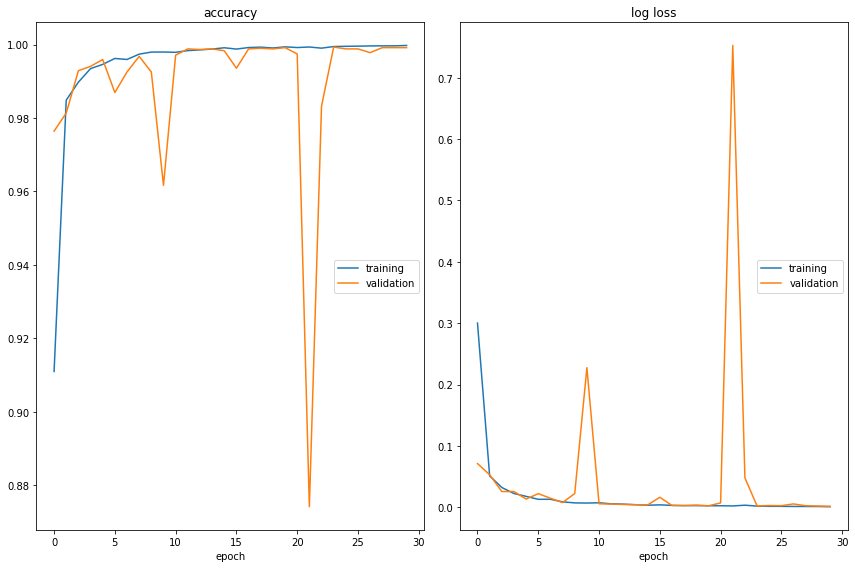

accuracy
	training         	 (min:    0.911, max:    1.000, cur:    1.000)
	validation       	 (min:    0.874, max:    0.999, cur:    0.999)
log loss
	training         	 (min:    0.001, max:    0.300, cur:    0.001)
	validation       	 (min:    0.002, max:    0.753, cur:    0.002)


(0.005982787813991308, 0.998869204673954, 0.01, 0.2)

In [30]:
#Visulaing the effect of momentum
#The learning rate is the same in both cases - 0.1, but momentum is 0.2 and 0.8 respectively 
# (0.8 in next cel)
train_model(0.01, 0.2, draw = True)

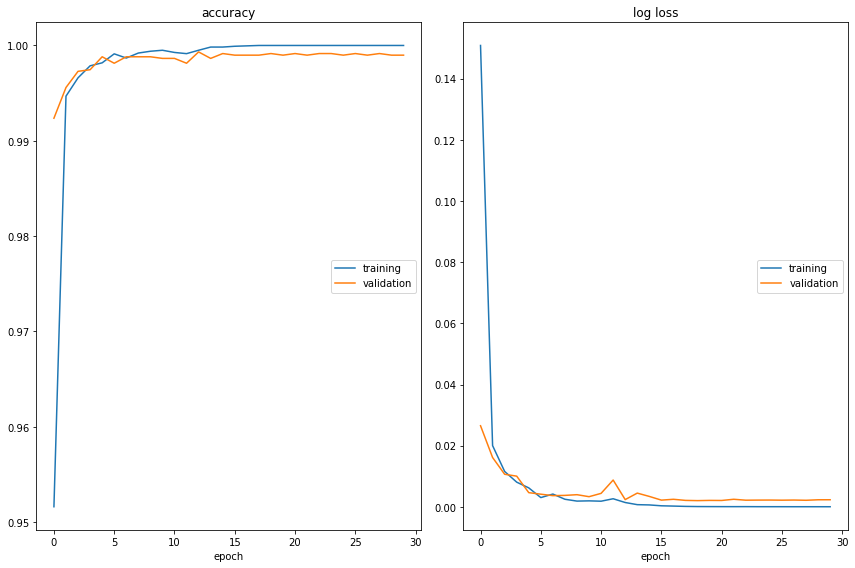

accuracy
	training         	 (min:    0.952, max:    1.000, cur:    1.000)
	validation       	 (min:    0.992, max:    0.999, cur:    0.999)
log loss
	training         	 (min:    0.000, max:    0.151, cur:    0.000)
	validation       	 (min:    0.002, max:    0.027, cur:    0.002)


(0.0074660275131464005, 0.998869204673954, 0.01, 0.8)

In [29]:
train_model(0.01, 0.8, draw = True)

It is clear that higher value of momentum leads to slightly better training in this case. Momentum accounts for all previous gradients and increases the step size to help get out of local minima points (so that a more important global minimum is found). 

In this case, too momentum of 0.2 is clearly not enough and leads to unstable, growing in magnitude oscilations. The accuracy drops dramatically at epoch 8]21, indicating inapropriate parameters choosen for training. The networks overshoots of local and global minimum and while the resulting log loss and accuracy are appropriate, the training process is poor. In such cases adding a decay term to the cost function can solve the problem (weight decay leads to the effect of shrinking of weights during backpropagation)

In [31]:
#The best hyperparameters are those that lead to highest accuracy and lowest loss
#Hence we look for minimum in the first element of stored results and for 
#maximum in the second 

#Finding the min loss value and corresponding hypermarameters
print(min(results, key = lambda t: t[0]))

#Finding the max accuracy value and corresponding hypermarameters
print(max(results, key = lambda t: t[1]))

(0.0035818254109472036, 0.9992461364493027, 0.1, 0.2)
(0.0035818254109472036, 0.9992461364493027, 0.1, 0.2)


## 6-Train with best hyperparameters [5 points]

Once you have your two best hyperparameters, retrain the model by combining your split datasets **as you see fit** and explain why you chose this particular combination. Report the final accuracy on the test set. Use *livelossplot* to plot the values of the training evolution and explain changes in performance with your new combination of datasets.

In [32]:
#We need to have the maximum amount of data when we train model on tuned hyperparameters, but we still 
#need 3 sets - training, validation and test set
print(len(medical_test))
print(len(medical_validate))
print(len(medical_train))
#We will combine test and train data sets (these are already available) and use validation set 
# as train set to evaluate the performance

5306
5896
47753


In [33]:
medical_training = TensorDataset(torch.stack(X_train), torch.Tensor(y_train).long())

In [35]:
print(len(medical_training))
print(len(medical_validate))

53059
5896


In [36]:
def train_model(lr, momentum, draw = True):
    set_seed(seed)
    model = LeNet5().to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr = lr,momentum=momentum)
    criterion = nn.CrossEntropyLoss()
  
    train_loader = DataLoader(medical_training, batch_size=batch_size, shuffle=True, num_workers=0)
    
    test_loader = DataLoader(medical_validate, batch_size=test_batch_size, shuffle=False, num_workers=0)
  
    liveloss = PlotLosses()
    for epoch in range(30):
        logs = {}
        train_loss, train_accuracy = train(model, optimizer, criterion, train_loader)

        logs['' + 'log loss'] = train_loss.item()
        logs['' + 'accuracy'] = train_accuracy.item()

        liveloss.update(logs)
        #This way we will only plot when nessesary(e.g. for best hyperparameters)
        if draw == True:
            liveloss.draw()
        
    #Here the function from lecture was modified slightly to include the evaluation on the test set
    #It is more reliable to check on the test set, as the model has never seen this data before
    #The function now returns the accuracy and lo9ss on the test set as well as parameters that yielded 
    #Corresponding Learning rate and momentum values are also returned for ease of documentation
    test_loss, test_accuracy = validate(model, criterion, test_loader)
    return model, test_loss.item(), test_accuracy.item()

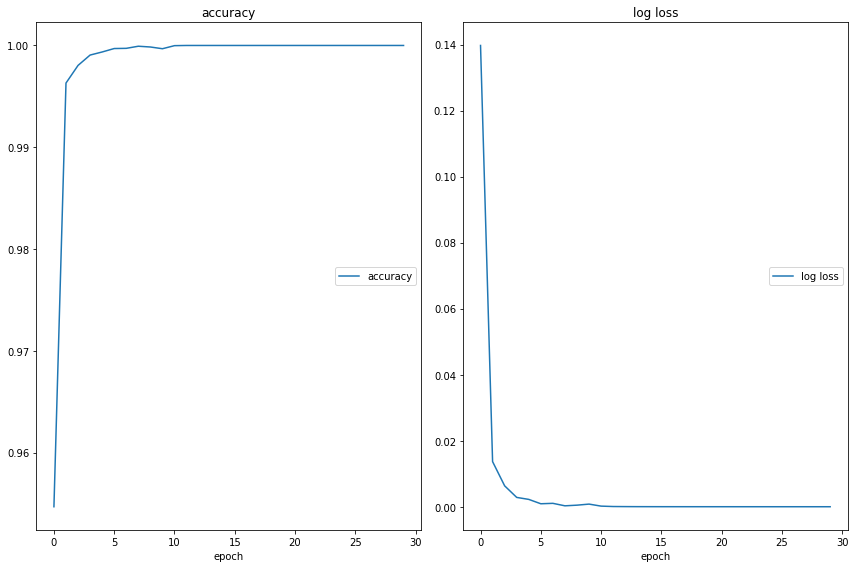

accuracy
	accuracy         	 (min:    0.955, max:    1.000, cur:    1.000)
log loss
	log loss         	 (min:    0.000, max:    0.140, cur:    0.000)


In [37]:
final_model = train_model(0.1, 0.2, draw = True)

In [38]:
print(final_model[1:])
print(results[0])

#After re-training our model on selected hyperparameters and more data 
#we see that accuracy has only slight improvement, but there is some decrease in loss. 
#The training plot is very smooth with rapid increase in accuracy and drop in loss, indicating
#good choice of hyperparameters.


(0.0013511201832443476, 0.9994911804613297)
(0.0035818254109472036, 0.9992461364493027, 0.1, 0.2)


## 7-Comparison with original LeNet implementation  [10 points]}
Read the paper *Gradient based learning applied to document recognition* provided. What are the main differences between their implementation and the one you are using in this coursework?

[**You only need to read and understand the paper until section** III. RESULTS AND COMPARISON WITH OTHER METHODS, *B. Results*, **included, which finishes on page 11 (you can ignore the rest)**]



Overall the main difference is that out LenNet-5 network is does not skip any connections anbd therefore has more trainable parameters. As well as all layers are activated with ReLU. In paper some network incorporates concept of sharing weights, used more complex sub-sampling layers instead of simple MaxPool where we have 0 trainable parameteres and uses sigmoid activation function (only on some layers, opposed to activation of all layers in our case).

A more detailed, layer-by-layer comparison is described below:

- Firstly the input dimention is different in out case - 64x64 and in paper 32*32, however this does not impact the training of network, In case of my method the difference of layer 1 would be pooling and stride values. Also, we activate the C1 layer with ReLU function, while in the paper no activation of first convolutional layer is mentioned.

- S2 layer is quite different. In our case we use MaxPooling layer and in paper they use subsampling. While, MaxPooling identifies the maximum pixel value in a grid and then processes that in output image, subsampling on the other hand is takes one pixel in the grid and replaces surrounding pixels of that grid by that pixel value in the output image. Hence in our case there is no trainable parameters in S2 layer. In paper they have different strategy - adding 4 inputs and multiplying them by trainable coeficinet and adding a trainable bias. The result is actiavted with sigmoid function. This results in S2 layer having 12 trainable parameters in paper and 0 in our implementation. 

- C3 layer in paper used a strategy of connecting S2 feature maps to selected C3 feature maps, which are documented ina table. This reduces the number of connections and forces a break of symetry in teh network. Different feature maps get different inputs and therefore extract different features. Therefore, in paper C3 has much less connections and consequently less trainable parameters - 1,516 (2,416 in our implementation)

- S4 layer is similar to S2 and C5 has a many trainable parameters as in our implementation. 

- S6 layer in paper is composed of Euclidian Radian Basis Function, while in our case it is just activated with ReLU function like all other layers. 

- Lastly, the Loss function is different - Cross Entropy Loss in our case and Minimum Mean Square Error (MSE) in paper. In our case we have gradients of the loss function is computed using standard algorism in backpropagation. But in paper it had to be modified to account for sharing weights - first derivatives are computed for each connection and then for connections that share the same parameter derivatives are added up.


## 8-Number of parameters in LeNet-5 [5 points]

Calculate how many trainable parameters the LeNet network you have implemented for this coursework has, and compare it to the number of parameters of the original LeNet network described in the paper you read in the previous question. Explain how you calculate the number of parameters for both cases.

[**answers that only contain the number of parameters without justification will be awarded 0 points**]

In [39]:
final_model[0]

LeNet5(
  (c1): Conv2d(1, 6, kernel_size=(5, 5), stride=(3, 3), padding=(11, 11))
  (s2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (c3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (s4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (c5): Linear(in_features=400, out_features=120, bias=True)
  (f6): Linear(in_features=120, out_features=84, bias=True)
  (output): Linear(in_features=84, out_features=10, bias=True)
  (act): ReLU()
)

Trainable params in Conv layers = ((width of filter* height filter * number of filters in the previous layer +1 ) * number of filters)
+1 is for bias term

Trainable params in Fully Connected layers = ((current layer neurons c * previous layer neurons p)+1*c).

In [537]:

c1 = ((5*5*1)+1)*6
s2 = 0 #no trainable parameters in MaxPool layers
c3 = ((5*5*6)+1)*16
s4 = 0 #no trainable parameters in MaxPool layers
c5 = (120 * 16*5*5) +1 *120
f6 = (84*120) +1*84
output = (10*84) +1 *10

total_trainable_parameters = np.sum([c1, s2, c3, s4, c5, f6, output])
total_trainable_parameters

61706

In [538]:
#Check if all calculations are correct
from torchsummary import summary
summary(final_model[0], (1, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             156
              ReLU-2            [-1, 6, 28, 28]               0
         MaxPool2d-3            [-1, 6, 14, 14]               0
              ReLU-4            [-1, 6, 14, 14]               0
            Conv2d-5           [-1, 16, 10, 10]           2,416
              ReLU-6           [-1, 16, 10, 10]               0
         MaxPool2d-7             [-1, 16, 5, 5]               0
              ReLU-8             [-1, 16, 5, 5]               0
            Linear-9                  [-1, 120]          48,120
             ReLU-10                  [-1, 120]               0
           Linear-11                   [-1, 84]          10,164
             ReLU-12                   [-1, 84]               0
           Linear-13                   [-1, 10]             850
Total params: 61,706
Trainable params: 

In [570]:
#Now calculating the number of trainable parameters in LeNet-5 in paper
#Layer 1 is the same as in our network and calculated using formula above

c_1 = ((5*5*1)+1)*6

#A total of 2 trainable parameters are requited for a sub-samplin kernel
#S2 consists of 6 sub-sampling kernels accourding to its input
#Hence number of trainable parameters is
s_2 = 6*2

#C3 consists of 16 mix-depth convolutional kernels that are illustrated in Table 1 in paper
#The calculations are performed following the exact description in the paper
#feature_maps*(kernel_size*number_of_feature_map_subsets_in_s2 + bias term)
c_3 = 6*(5*5*3+1) + 6*(5*5*4+1) + 3*(5*5*4+1) + 1*(5*5*6+1)

s_4 = 16*2

c_5 = (120 * 16*5*5) +1 *120

f_6 = (84*120) +1*84
#While output is made of RBF function each unit is connected to all its 84 inputs
output_ = (10*84) +1 *10

total_trainable_parameters_original = np.sum([c_1, s_2, c_3, s_4, c_5, f_6, output_])
total_trainable_parameters_original

60850

## 9-Visualising loss landscapes paper - 1 [10 points]

Read the provided paper *Visualising the Loss Landscape of Neural Nets*. This paper contains a lot of advanced concepts, but you only need to read and understand it well up to and including section 4 (Proposed Visualisation: Filter-Wise Normalisation) to answer the questions below. In section 4 you don't need to fully understand the rationale for doing Filter-Wise Normalisation, but you do need to understand what Filter-Wise Normalisation is.

Answer the following question (in a markdown cell):
- What are the dimensions of the parameters $\delta$, $\eta$, $\alpha$ and $\beta$ in equation (1) using your LeNet network? [5 points]

- Describe what is the role of each of these parameters [5 points]

$\digamma$($\alpha$, $\beta$) = L($\sigma$* + $\alpha$$\delta$ + $\beta$$\eta$)

$\sigma$* list of all the parameters in a neural network optimised for global minimum - 61706 in our model

$\delta$ and $\eta$ are direction vectors, they represent directions in each dimension of $\sigma$* I.e., $\delta$ and $\eta$ have the same dimensionality as $\sigma$*, which could both be sampled from a random Gaussian.

$\alpha$ and $\beta$ are scalars representing steps taken in each direction.



Basically function works like this:

We take any random or optimised set of parameters $\sigma$* and venture in 2 directions - $\delta$ and $\eta$. In both of these directions we take small steps - $\alpha$ and $\beta$, respectively. The resulting graph is, therefore, a function of $\alpha$ and $\beta$. Since $\delta$ and $\eta$ are direction vectors, they represent directions in each dimension of 𝛉*.


## 10-Visualise loss landscapes - 2 [20 points]

Use the formula described in equation (1) in the paper in combination with the Filter-Wise Normalisation to generate landscape plots in these two cases:
- your final trained model (output of question *6*).
- your randomly initialised model.

In both cases, use 25 values for $\alpha$ and 25 values for $\beta$ to generate a 2D plot with 625 points.

Use the provided snippets of code in the Jupyter Notebook template to assist you in generating the plots and to guide you in the functions you will need to implement.

Analyse, compare and discuss your plots. How are they different? and why? Justify the choices you make along the generation process of plotting the loss landscapes (for example, but not limited to, the range your choose for your $\alpha$ and $\beta$ values).

[**you can use a subset of the data to generate the plots, but explain what effect this will have in the results**]

In [116]:
# The following snippets of code are only to assist you. You can decide to use 
# them or not. They are only intended to provide you with some functionality
#  you may find useful when trying to generate the loss landscape plots.


# function to create random directions:
def create_random_directions(weights, ignore1D=False, seed=42):
    torch.manual_seed(seed)
    direction = [torch.randn(w.size()).to(device) for w in weights]
    
    # apply filter normalisation, where every perturbation d in direction has the same norm as its corresponding w in weights
    for d, w in zip(direction, weights):
        if ignore1D and d.dim() <= 1:
            d.fill_(0)
        d.mul_(w.norm()/(d.norm() + 1e-10)) # add small perturbation to avoid division by zero

    return direction


# function to update weigths
def update_weights(model, origin_weights, x_dir, y_dir, dx=0.1, dy=0.1):
    updates = [x.to(device)*dx + y.to(device)*dy for (x, y) in zip(x_dir, y_dir)]
    for (p, w, u) in zip(model.parameters(), origin_weights, updates):
        p.data = w + u
    return None


# function to plot loss landscape as a surface
def plot_loss_landscape(xx, yy, loss_landscape):
    fig, ax = plt.subplots(figsize=(8, 8),subplot_kw={"projection": "3d"})
    surf = ax.plot_surface(xx, yy, loss_landscape, cmap='viridis', edgecolor='none',
                       linewidth=0, antialiased=True,  rstride=1, cstride=1,)
    ax.set_xlabel(r'X')
    ax.set_ylabel(r'Y')
    ax.set_zlabel(r'Loss')
    fig.colorbar(surf, shrink=0.5, aspect=5)
    plt.show()


# function to plot loss landscape as a contour
def contour_loss_landscape(xx, yy, loss_landscape):
    fig, ax = plt.subplots(figsize=(7, 7))
    surf = ax.contourf(xx, yy, loss_landscape, cmap='viridis', levels=100)
    ax.set_xlabel(r'X')
    ax.set_ylabel(r'Y')
    fig.colorbar(surf, shrink=0.5, aspect=5)
    plt.show()


# BONUS: functions to compute the angle between 2 random vectors
# in high-dimensional spaces two random vectors are quite likely to be
# orthogonal (or almost). No points involved here, this is just for fun!
#
def angle(vec1, vec2):
    return torch.acos(torch.dot(vec1, vec2)/(vec1.norm()*vec2.norm())).item()

def rad2deg(angle):
    return angle*180/np.pi

def concat_torch_list(torch_list):
    for i, t in enumerate(torch_list):
        torch_list[i] = t.flatten()
    return torch.cat(torch_list)

In [117]:
#We will need to convert model's parameters to vector for calculations and then back to parameters to 
#calculate losses, hence these imports
from torch.nn.utils import ( parameters_to_vector as Params2Vec, vector_to_parameters as Vec2Params)

theta_ast = Params2Vec(final_model[0].parameters())

#Generating random direction vectors delta and eta
delta = create_random_directions(theta_ast, ignore1D=False, seed=42)
eta = create_random_directions(theta_ast, ignore1D=False, seed=21)


In [118]:
#Updating weights in a model using filter-wise normalisation
update_weights(final_model[0], final_model[0].parameters(), delta, eta)


In [200]:
#defining the loss function
loss_fn = torch.nn.CrossEntropyLoss()

#Recreating function 1 from paper
def function_1(alpha, beta, theta_ast, delta, eta):
    a =  torch.Tensor([alpha * x for x in delta])
    b =  torch.Tensor([beta * x for x in eta])
    return theta_ast + a + b

In [197]:
alpha = torch.linspace(-10, 10, 25)
beta = torch.linspace(-10, 10, 25)

space = []

for i in alpha:
    for j in beta:
        space.append(function_1(i, j, theta_ast, delta, eta))

In [209]:
#list where all losses will be stored 
losses = []
for i in range(len(space)):
    #for each tensor computed we assign this tensor as parameters (weights) to model
    Vec2Params(space[i], final_model[0].parameters())
    #now, using the validate function and dataloader of the whole dataset (it returns
    #loss and accuracy, so we need to take value at index 0) we compute the loss and store it in losses list
    losses.append(validate(final_model[0], loss_fn, data_loder_normalised)[0])
    #As the loop take a long time to run we print out several values to track the progress
    if i %50 == 0:
        print(i, losses[i])

0 tensor(9121851.)
50 tensor(5837772.)
100 tensor(3728168.7500)
150 tensor(2553635.5000)
200 tensor(1973102.7500)
250 tensor(1820733.7500)
300 tensor(1932151.)
350 tensor(2345871.5000)
400 tensor(3203523.2500)
450 tensor(4598605.5000)
500 tensor(7022752.)
550 tensor(10699364.)
600 tensor(16242971.)


In [219]:
losses_landscape = []
for i in range(len(losses)):
    losses_landscape.append(losses[i].item())


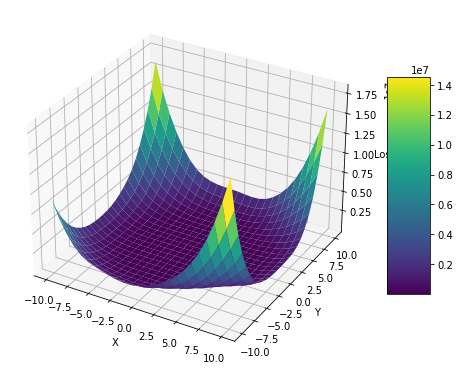

In [234]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import numpy as np

alpha = np.array(alpha)
beta = np.array(beta)

X, Y = np.meshgrid(alpha, beta)
losses = np.array(losses_landscape).reshape(25, 25)

plot_loss_landscape(X, Y, losses)

As we have trained our model and the loss was very low - 0.0035 is is likely that any perturbations to the parameters that yielded this result would make model's loss larger. The plot indicates this very well - where values of alpha and beta are at 0 we can see the minimum loss and any increase of these values leads to increase in loss. 

## Repeating the process for randomly initialised model

In [240]:
model_random = LeNet5().to(device)

theta_ast_random = Params2Vec(model_random.parameters())

#Generating random direction vectors delta and eta
delta_random = create_random_directions(theta_ast_random, ignore1D=False, seed=38)
eta_random = create_random_directions(theta_ast_random, ignore1D=False, seed=24)


In [241]:
#Updating weights in a model using filter-wise normalisation
update_weights(model, model.parameters(), delta_random, eta_random)

In [242]:
space = []

for i in alpha:
    for j in beta:
        space.append(function_1(i, j, theta_ast_random, delta_random, eta_random))

In [ ]:
#list where all losses will be stored 
losses_random = []
for i in range(len(space)):
    #for each tensor computed we assign this tensor as parameters (weights) to model
    Vec2Params(space[i], model.parameters())
    #now, using the validate function and dataloader of the whole dataset (it returns
    #loss and accuracy, so we need to take value at index 0) we compute the loss and store it in losses list
    losses_random.append(validate(model, loss_fn, data_loder_normalised)[0])
    #As the loop take a long time to run we print out several values to track the progress
    if i %50 == 0:
        print(i, losses_random[i])

0 tensor(20847.0371)
50 tensor(13337.9043)
100 tensor(8583.8174)
150 tensor(5922.2754)
200 tensor(4597.3267)
250 tensor(4077.3906)
300 tensor(4193.0020)
350 tensor(4892.4365)
400 tensor(6124.4731)
450 tensor(7946.3032)
500 tensor(10814.1455)
550 tensor(15261.8574)
600 tensor(22446.6797)


It has taken a lot of time 3 hours+ for ithe loss calculations of every parametr set to get calculated, hence I have run out of time to compute all 625 losses for randomly generated model. But even without the exact calculatios the predictions are the following:
- it is likely that shape would be similar to ice-cream cones, with falls and drops of losses around the whole surface area, This is because the model was not trained on medical-minstd data at all and hence any pertubation to weighst yield either better or lower loss. 
- with pre-trained model the weighst are in their optimal postion - any pertubations increse tyhe loss value, But with brandom initialisarions - thre is a possibility that pertubatiuons in one or another direction can revealn how we can modify model's weighst to improve arrucracy and loss values 